In [2]:
from edge_detection.model import edge_detection
from edge_smoothing.model import edge_smoothing
import matplotlib.pyplot as plt
import cv2
import io
import numpy as np
from PIL import Image

In [32]:
image_path = '../public/Glazed-Donut.jpg'
with open(image_path, 'rb') as f:
    image_bytes = f.read()

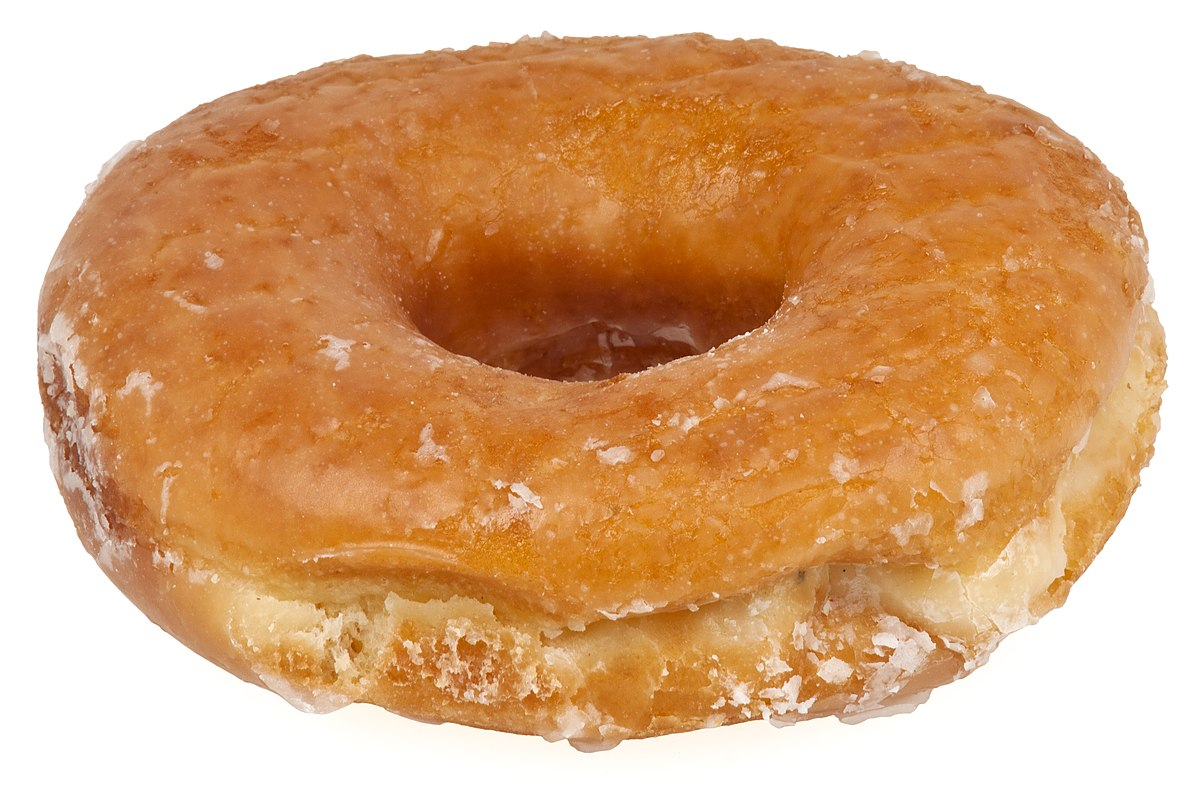

In [33]:
image = Image.open(io.BytesIO(image_bytes))
image

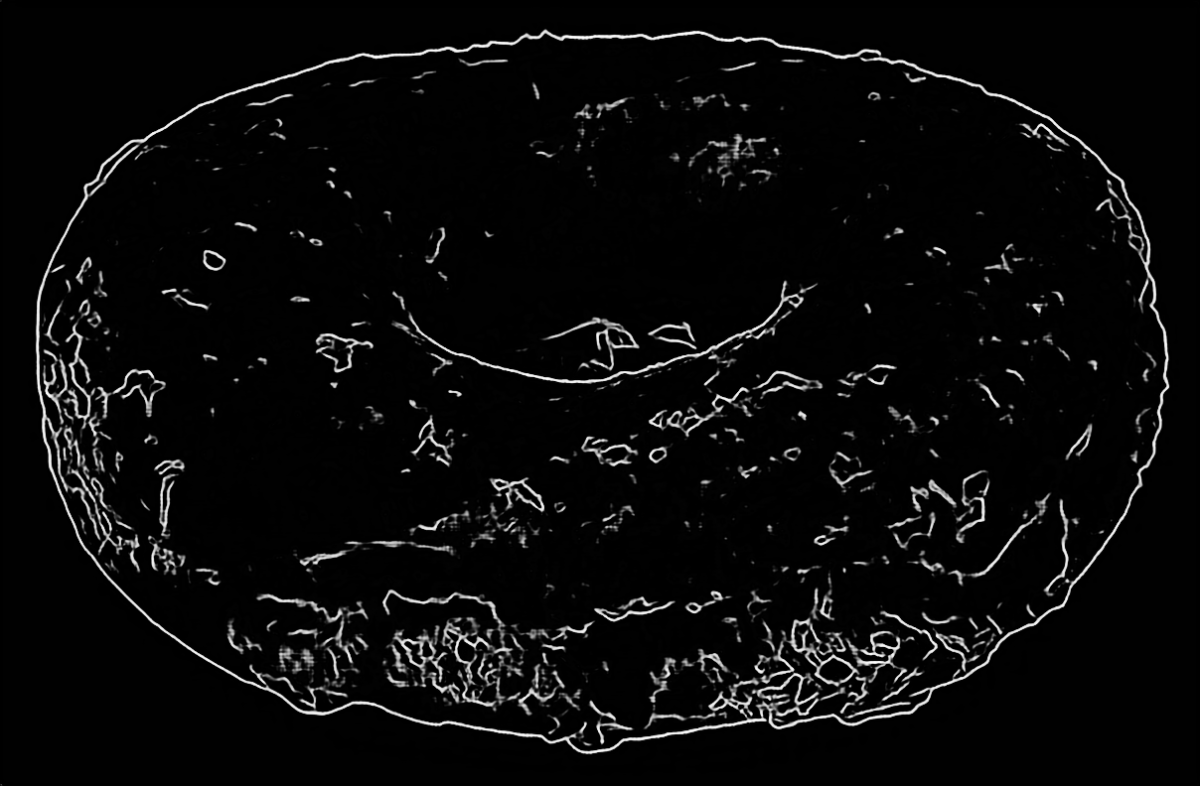

In [34]:
medium_img_bytes = edge_detection(image_bytes, "medium")
medium_img = Image.open(io.BytesIO(medium_img_bytes))
medium_img

In [35]:
from PIL import Image
import cv2
import numpy as np
import PIL as pil
from matplotlib import pyplot as plt
import io
import skimage.filters as filters


def opening(img, kernel, iterations):
    """
    Erodes an image. Method to execute opening (gaps become larger). the kernel
    size and iteration amount affects how much opening occurs

    Args:
        img: binary file representing an image JPG or PNG
        kernel: a tuple representing a valid kernel value
        iterations: the number of times the image is to be eroded

    Returns:
        A binary file representing an image JPG or PNG
    """
    img_erosion = cv2.erode(img, kernel, iterations=iterations)
    # img_dilation = cv2.dilate(img_erosion, kernel, iterations=iterations)
    return img_erosion


def closing(img, kernel, iterations):
    """
    Closes any gaps in the image edges. Method to execute closing (gaps become
    smaller). the kernel size and iteration amount affects how much closing occurs.

    Args:
        img: binary file representing an image JPG or PNG
        kernel: a tuple representing a valid kernel value
        iterations: the number of times to apply closing on the image

    Returns:
        A binary file representing an image JPG or PNG
    """
    closed_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=1)
    img_dilation = cv2.dilate(closed_img, kernel, iterations=iterations)
    # img_erosion = cv2.erode(img_dilation, kernel, iterations=iterations)
    return img_dilation


def contour_preparation(img):
    """
    Prepares the image for contour extraction

    Args:
        img: binary file representing an image JPG or PNG

    Returns:
        A binary file representing an image JPG or PNG
    """
    # Dilate the edges before denoising
    # Necessary to prevent thin prominent lines from weathering away
    dilated_edges = cv2.dilate(img, (3, 3), iterations=1)

    # Denoising the image
    dst = cv2.fastNlMeansDenoising(dilated_edges, 11, 21, 25)

    # Setting a threshold for contour finding
    # Getting all colored pixels and setting them to white if above the threshold
    ret, thresh = cv2.threshold(dst, 120, 255, cv2.THRESH_BINARY)

    return thresh


def contour_image(img):
    """
    Contours the image and only extracts the relevant contours

    Args:
        img: binary file representing an image JPG or PNG

    Returns:
        A binary file representing an image JPG or PNG
    """

    # Convert the image to grayscale so that it can be handled by the "findContours" method
    # gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Ensure the image is in 8-bit format
    gray_img = cv2.convertScaleAbs(img)

    # Now you can find contours on the grayscale image
    contours, hierarchy = cv2.findContours(
        gray_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Establish a threshold for the minimum area of a contour
    min_area_threshold = 10

    # Filter out the contours with small area
    filtered_contours = [contour for contour in contours if cv2.contourArea(
        contour) > min_area_threshold]

    return filtered_contours


def denoising(img):
    """
    Denoises an image by removing any pixels that aren't a black color.
    The image is sharpened after denoising.

    Args:
        img: binary file representing an image JPG or PNG

    Returns:
        A binary file representing an image JPG or PNG
    """
    dst = cv2.fastNlMeansDenoising(img, None, 11, 25, 43)

    for y in range(dst.shape[0]):  # Loop over rows
        for x in range(dst.shape[1]):  # Loop over columns
            if dst[y][x] <= 0:
                dst[y][x] = 0

    # Create the sharpening kernel
    sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

    # Sharpen the image
    sharpened_image = cv2.filter2D(dst, -1, sharpen_kernel)

    return sharpened_image


def display(img_og, img_new):
    """
    Graphs and displays the original image and the altered image

    Args:
        img_og: binary file representing the original JPG or PNG image
        img_new: binary file representing the altered JPG or PNG image

    Returns:
        A binary file representing an image JPG or PNG
    """
    plt.subplot(121), plt.imshow(img_og, cmap='gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(img_new, cmap='gray')
    plt.title('Altered Image'), plt.xticks([]), plt.yticks([])
    plt.show()


# Run the edge smoothing function on an image
# img = cv2.imread(
#     '/Users/darrenkey/Documents/TEED/result/BIPED2CLASSIC/fused/bear.png', 0)
# inv_img = cv2.bitwise_not(img)

# edge_smoothing(inv_img)

# display(img, inv_img)


In [39]:

def edge_smoothing(f: bytes) -> bytes:
    """
    Converts an edge detection output into a coloring book outline, including
    all necessary postprocessing

    Args:
        f: binary file representing an image JPG or PNG

    Returns:
        A binary file representing an image JPG or PNG
    """
    # Converts binary file to numpy array
    image = np.array(Image.open(io.BytesIO(f)))

    # Sets the kernels to be used for opening and closing
    # These kernels can be adjusted to be the best-performing variant.
    kernel_opening = (5, 5)
    kernel_closing = (3, 3)

    # Prepare the image to be contoured
    opened_img = opening(image, kernel_opening, 1)

    
    prepared_img = contour_preparation(opened_img)
    # denoised_img = denoising(prepared_img)
    # display(image, denoised_img)

    # Contour the image
    # contours = contour_image(denoised_img)

    # Enhance the image for plotting preparation
    # Create an empty image to draw filtered contours
    # filtered_image = np.zeros_like(image)

    # Draw the filtered contours on the empty image
    # new_image = cv2.drawContours(
    # filtered_image, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

    # Close all of the edges
    closed_img = closing(prepared_img, kernel_closing, 2)

    # Invert the image
    # inverted_img = cv2.bitwise_not(closed_img)

    # Display the original and enhanced image
    # display(image, closed_img)

    # byteImg = inverted_img.tobytes()

    # Convert numpy array back to PIL Image
    segmented_img_pil = Image.fromarray(
        cv2.cvtColor(closed_img, cv2.COLOR_RGB2BGR))

    # Save the segmented image to bytes
    img_byte_arr = io.BytesIO()
    # You can change 'PNG' to 'JPEG' if you prefer
    segmented_img_pil.save(img_byte_arr, format='JPEG')
    img_byte_arr = img_byte_arr.getvalue()

    return img_byte_arr

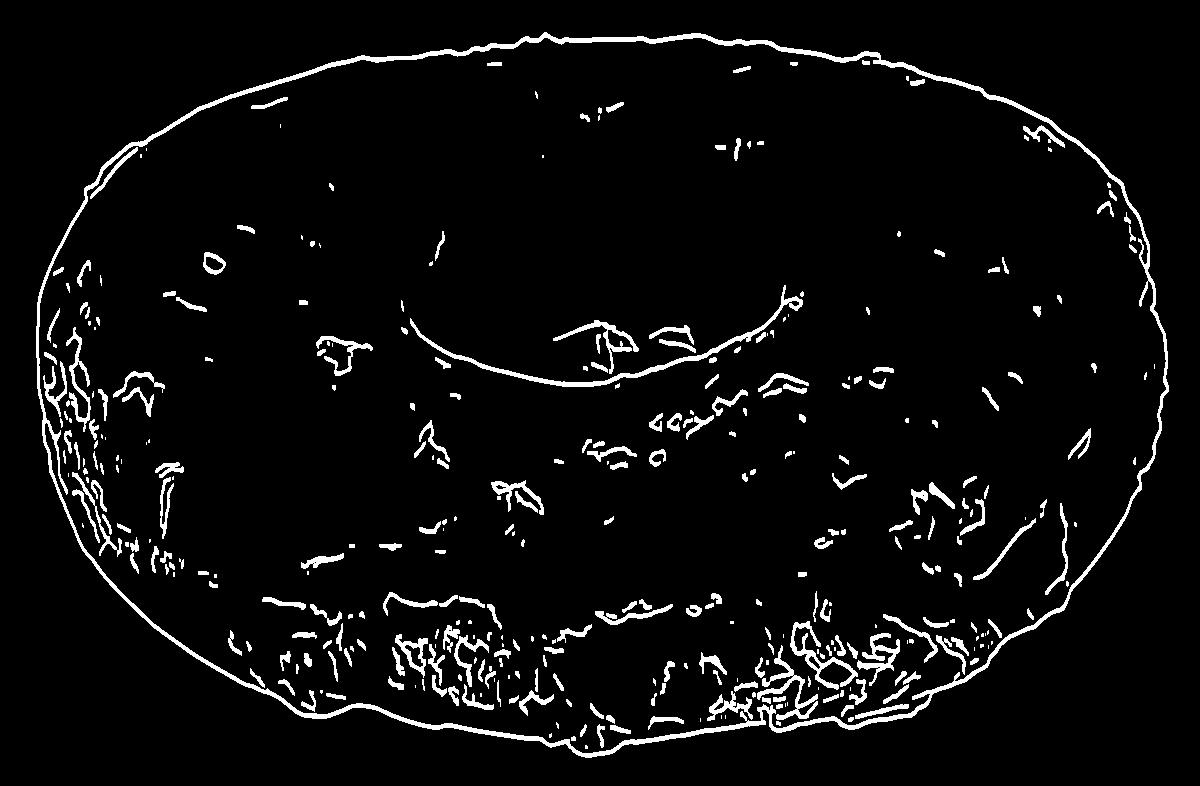

In [40]:
medium_smoothing = edge_smoothing(medium_img_bytes)
Image.open(io.BytesIO(medium_smoothing))

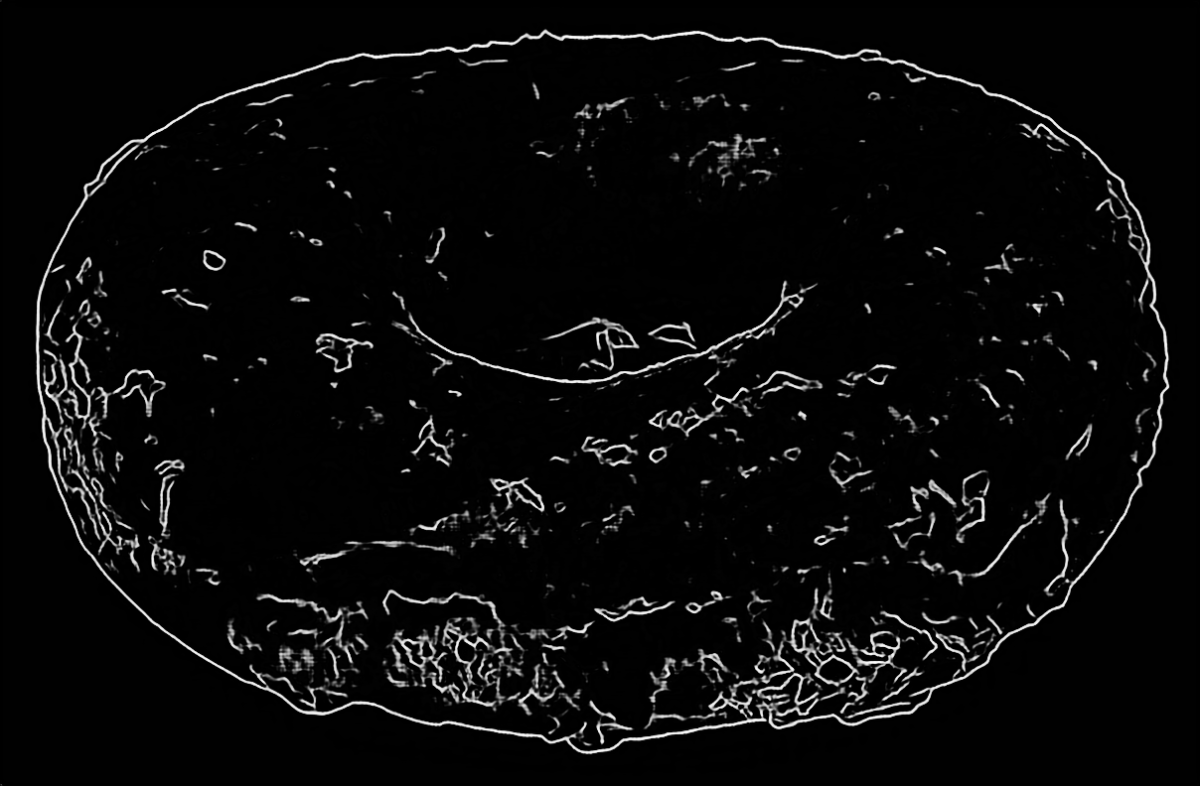

In [38]:
medium_smoothing = edge_smoothing(medium_img_bytes)
Image.open(io.BytesIO(medium_img_bytes))

In [22]:
image = np.array(Image.open(io.BytesIO(medium_img_bytes)))

# Sets the kernels to be used for opening and closing
# These kernels can be adjusted to be the best-performing variant.
kernel_opening = (5, 5)
kernel_closing = (3, 3)

# Prepare the image to be contoured
opened_img = opening(image, kernel_opening, 1)


Image.fromarray(opened_img), Image.fromarray()
# prepared_img = contour_preparation(opened_img)
# # denoised_img = denoising(prepared_img)
# # display(image, denoised_img)

# # Contour the image
# # contours = contour_image(denoised_img)

# # Enhance the image for plotting preparation
# # Create an empty image to draw filtered contours
# # filtered_image = np.zeros_like(image)

# # Draw the filtered contours on the empty image
# # new_image = cv2.drawContours(
# # filtered_image, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

# # Close all of the edges
# closed_img = closing(prepared_img, kernel_closing, 2)

# # Invert the image
# # inverted_img = cv2.bitwise_not(closed_img)

# # Display the original and enhanced image
# # display(image, closed_img)

# # byteImg = inverted_img.tobytes()

# # Convert numpy array back to PIL Image
# segmented_img_pil = Image.fromarray(
#     cv2.cvtColor(closed_img, cv2.COLOR_RGB2BGR))

# # Save the segmented image to bytes
# img_byte_arr = io.BytesIO()
# # You can change 'PNG' to 'JPEG' if you prefer
# segmented_img_pil.save(img_byte_arr, format='JPEG')
# img_byte_arr = img_byte_arr.getvalue()

TypeError: fromarray() missing 1 required positional argument: 'obj'